# Exercise 2: Magnetostatics with Eddy Currents

In [1]:
using LinearAlgebra
using SparseArrays

using Plots
using LaTeXStrings

using Gmsh: gmsh

# Import project configuration
include(joinpath(dirname(dirname(@__FILE__)), "config.jl"))

# Get paths
paths = get_project_paths("ta_example_1d")

println("Base directory: ", paths["BASE_DIR"])
println("Geometry directory: ", paths["GEO_DIR"])
println("Output directory: ", paths["OUTPUT_DIR"])

Base directory: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/ta_example_1d
Geometry directory: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/ta_example_1d/geo
Output directory: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/ta_example_1d/output


# Theory
If we now also consider that the involved materials have a non-zero conductivity $\sigma$, the current density expression must change. We will split it into an _imposed_ current density $J_0$ and a _conduction_ current density $J_c$.
$$ \mathbf{J} = \mathbf{J}_0 + \mathbf{J}_c \qquad \mathbf{J}_c = \sigma \mathbf{E} $$
Using Maxwell's equations, it can be derived that the electric field is
$$ \mathbf{E} = -\nabla V - \frac{\partial \mathbf{A}}{\partial t} $$
We will make two assumptions: First, the electric potential $V$ is zero. Second, we consider _time-harmonic_ quantities.

## 1D Differential Equation
Substituting the equations derived above into the differential equation that we discussed in the previous exercise, we obtain
$$ -\frac{\partial}{\partial x} \left[ \nu(x) \frac{\partial A_z(x)}{\partial x} \right] + j\omega\sigma(x) A_z(x) = J_0(x) $$
The equation is quite similar to the one we solved in the previous exercise, but has an additional term representing the eddy currents. Because of the time-harmonic assumption, the time differential has simplified to multiplication by $j\omega$.

## Variational Form
The variational form is also quite similar to the one that was previously derived. It, too, has an additional term for the eddy currents.
$$ -\int_\Omega \frac{\partial}{\partial x} \left[ \nu(x) \frac{\partial A_z(x)}{\partial x} \right] v_k(x) dx + j\omega \int_\Omega \sigma(x) A_z(x) v_k(x) dx = \int_\Omega J_0(x) v_k(x) dx \qquad 1 \le k \le N $$
The eddy current term corresponds to the so-called _mass matrix_, which often appears in problems with a dependence on time. Rewriting the term corresponding to the stiffness matrix, we obtain
$$ \int_\Omega \nu(x) \frac{\partial A_z(x)}{\partial x} \frac{\partial v_k(x)}{\partial x} dx + j\omega \int_\Omega \sigma(x) A_z(x) v_k(x) dx = \int_\Omega J_0(x) v_k(x) dx \qquad 1 \le k \le N $$
where the boundary contribution is again zero because of the two homogeneous Dirichlet conditions.

## Matrix Equations & Implementation
For this problem, two matrix contributions must be determined: the _stiffness_ and _mass_ matrices. These calculations are presented in a separate notebook, and implementation details will be highlighted in the respective sections.

# Define Geometry
We will first load the previously defined geometry in gmsh and extract the nodes, elements, and physical domains.

In [3]:
gmsh.finalize();
gmsh.initialize();

In [5]:
gmsh.open(joinpath(paths["GEO_DIR"], "coil_geo.msh"))

# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

Info    : Reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/ta_example_1d/geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/ta_example_1d/geo/coil_geo.msh'


In [6]:
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 4)
e_group = zeros(1,nelements)

for element_id in 1:nelements
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1]) # Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1]) # Coil left
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1]) # Coil right
    
    if G1 == 2
        e_group[element_id] = 1;
    elseif G2 == 2
        e_group[element_id] = 2;
    elseif G3 == 2
        e_group[element_id] = 3;
    elseif G4 == 2
        e_group[element_id] = 4;
    end
end

# Linear Elements
Because of the time-harmonic problem, we must now solve a _complex_ system of equations. This is reflected in the contribution to the $A$ matrix, which is complex. Note that we could also make windings with different phase shifts by letting the source term be complex.

## Matrix Assembly
To allow for complex matrices, we must define the type of the matrix to be complex float point numbers.
```julia
A = zeros(Complex{Float64}, N, N);
```
Then, the matrix contributions are given by
$$ A_{e_i} = \int_{e_i} \nu(x) \begin{bmatrix}
    \phi_i^\prime \phi_i^{\prime} & \phi_i^\prime \phi_{i+1}^{\prime} \\
    \phi_i^\prime \phi_{i+1}^{\prime} & \phi_{i+1}^\prime \phi_{i+1}^{\prime}
\end{bmatrix} dx + j\omega \int_{e_i} \sigma(x) \begin{bmatrix}
    \phi_i \phi_i & \phi_i \phi_{i+1} \\
    \phi_i \phi_{i+1} & \phi_{i+1} \phi_{i+1} \\
\end{bmatrix} dx = \frac{\nu(e_i)}{h} \begin{bmatrix}
    1 & -1 \\ -1 & 1
\end{bmatrix} + \frac{j\omega\sigma(e_i) h}{6} \begin{bmatrix}
    2 & 1 \\ 1 & 2
\end{bmatrix}
$$
The first term is the stiffness matrix, and the second term is the mass matrix.

## Post-processing
In addition to the previously derived magnetic flux density, we can now also determine the induced current density $J_{eddy}$ during post-processing.
$$ J_{eddy}(x) = j\omega\sigma(x) A_z(x) $$

In [7]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

mu0 = 4e-7 * pi;
mu_r = 1500;
fmu(group_id) = mu0 + (mu_r - 1) * mu0 * (group_id == 2);
fnu(group_id) = 1 / fmu(group_id);
fnu_elem = map(fnu, e_group);

sigma_core = 1e2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

freq  = 0.2e6;
omega = 2*pi*freq;

In [8]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
N = length(x);
points = collect( [x[i], x[i+1]] for i in 1:N-1) 
edges  = collect( [i, i+1] for i in 1:N-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(Complex{Float64}, N, N);
f = zeros(Complex{Float64}, N); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xr = points[i,:][1]
    h = xr - xl;
    
    floc = fsource_elem[i] * h / 2 * [1; 1];
    Aloc = fnu_elem[i] / h * [1 -1; -1 1] + 1im * omega * fsigma_elem[i] * h * [1/3 1/6; 1/6 1/3]; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
A[end,:] = zeros(N);  A[end,end] = 1;      f[end] = 0;

#..solve the linear system
u  = A \ f;

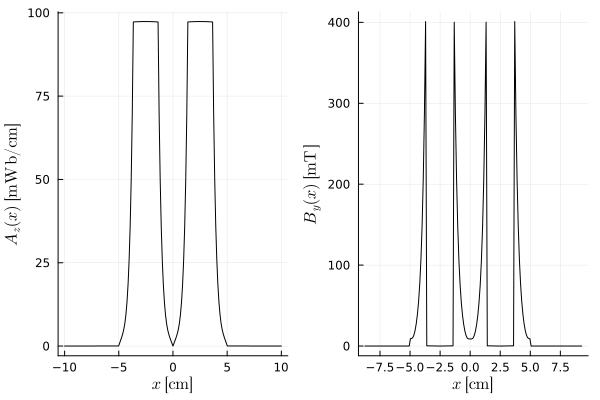

In [11]:
# Post-processing
xmid  = diff(x) / 2 + x[1:end-1];
ux    = diff(u) ./ diff(x);
Jeddy = 1im * omega * Transpose(fsigma_elem) .* (u[1:end-1] + u[2:end]) / 2;

# Plot
p1 = plot(x * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(xmid * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

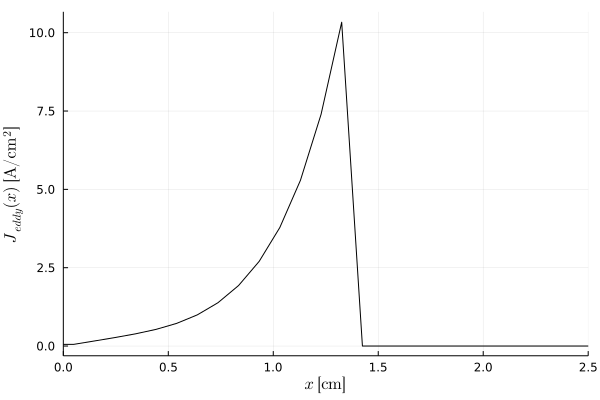

In [ ]:
plot(xmid * 1e2, norm.(Jeddy) * 1e-4, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"J_{eddy}(x)\ \mathrm{[A/cm^2]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

[ Info: Saved animation to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/ta_example_1d/output/eddy_currents_time_linear.gif


Plots.AnimatedGif("/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/ta_example_1d/output/eddy_currents_time_linear.gif")
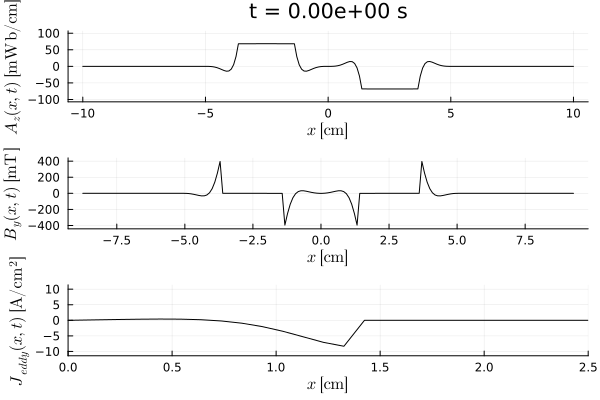

In [15]:
using Plots
using Printf


# Define time vector for one period
T = 2*pi / omega
t_vec = range(0, T, length=100)

# Create animation
anim = @animate for t_step in t_vec
    # Calculate real part of quantities at time t_step
    u_real = real.(u * exp(1im * omega * t_step))
    ux_real = real.(ux * exp(1im * omega * t_step))
    Jeddy_real = real.(Jeddy * exp(1im * omega * t_step))

    # Plot A_z
    p1 = plot(x * 1e2, u_real * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x, t)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false, title = @sprintf("t = %.2e s", t_step), ylims=extrema(real.(u * transpose(exp.(1im * omega * t_vec)))) .* 1e5 .* 1.1)

    # Plot B_y
    p2 = plot(xmid * 1e2, ux_real * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x, t)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false, ylims=extrema(real.(ux * transpose(exp.(1im * omega * t_vec)))) .* 1e3 .* 1.1)

    # Plot J_eddy
    p3 = plot(xmid * 1e2, Jeddy_real * 1e-4, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"J_{eddy}(x, t)\ \mathrm{[A/cm^2]}", color = :black, lw = 1, legend = false, xlims=(0, 2.5), ylims=extrema(real.(Jeddy * transpose(exp.(1im * omega * t_vec)))) .* 1e-4 .* 1.1)

    # Combine plots
    plot(p1, p2, p3, layout = (3, 1))
end

# Save animation as GIF
gif(anim, joinpath(paths["OUTPUT_DIR"], "eddy_currents_time_linear.gif"), fps = 15)

# Quadratic Elements
This implementation is very similar to what has been presented before. The details consist of
- Eddy currents as shown above.
- Quadratic elements as discussed in the previous exercise.

In [ ]:
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

In [ ]:
#..Initialize global matrix and right-hand side value 
A = zeros(Complex{Float64}, Na, Na); 
f = zeros(Complex{Float64}, Na); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    h = xr - xl;
    
    floc = fsource_elem[i] * h / 6 * [1; 4; 1];
    Aloc = fnu_elem[i] / (3 * h) * [7 -8 1; -8 16 -8; 1 -8 7] + 1im * omega * fsigma_elem[i] * h * [2/15 1/15 1/30; 1/15 8/15 -1/15; 1/30 -1/15 2/15];

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,:]   = zeros(Na);  A[1,1]     = 1;      f[1]   = 0;
A[end,:] = zeros(Na);  A[end,end] = 1;      f[end] = 0;

#..solve the linear system
u  = A \ f;

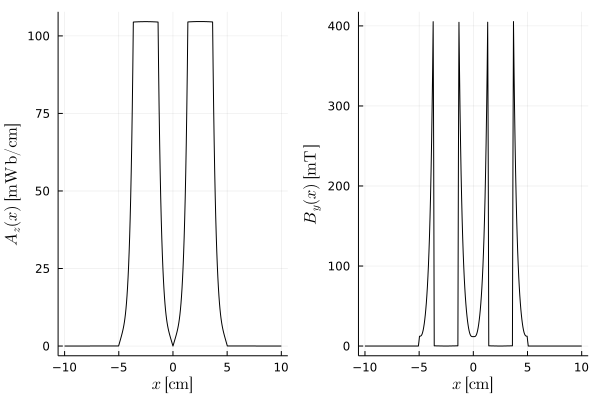

In [ ]:
# Post-processing
ux    = zeros(Complex{Float64}, Na);
Jeddy = zeros(Complex{Float64}, Na);

Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    ul, um, ur = u[edges[i]];
    
    dux = [ul um ur] * Emat / (xr - xl);
    
    ux[edges[i]] += [dux[1]/2; dux[2]; dux[3]/2];
    
    if(i < N-1 && fsigma_elem[i+1] <= 0)
        Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur]';
    elseif(i > 2 && fsigma_elem[i-1] <= 0)
        Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul um ur/2]';
    else
        Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur/2]';
    end
end

# Plot
p1 = plot(X * 1e2, norm.(u) * 1e5, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"A_z(x)\ \mathrm{[mWb/cm]}", color = :black, lw = 1, legend = false);
p2 = plot(X * 1e2, norm.(ux) * 1e3, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"B_y(x)\ \mathrm{[mT]}", color = :black, lw = 1, legend = false);

plot(p1, p2)

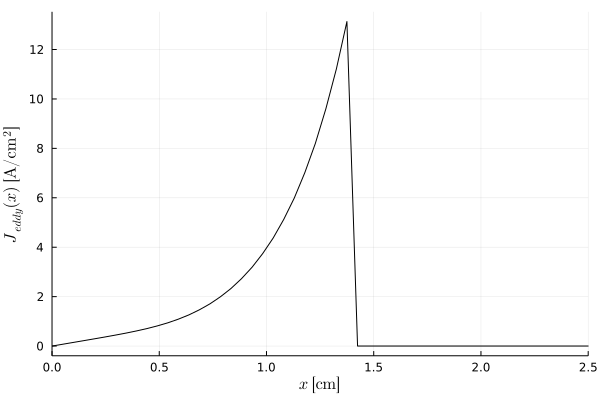

In [ ]:
plot(X * 1e2, norm.(Jeddy) * 1e-4, xlabel = L"x\ \mathrm{[cm]}", ylabel = L"J_{eddy}(x)\ \mathrm{[A/cm^2]}", color = :black, lw = 1, legend = false)
xlims!((0, 2.5))

Below, the skin depth is calculated analytically and from the FEM solution (using a polynomial curve fit and non-linear solver to find the zero).

In [ ]:
using CurveFit
using NLsolve

In [ ]:
## Analytical
delta_analytical = 1 / sqrt(pi * mu0 * mu_r * sigma_core * freq) * 1e3;

## FEM
Js = maximum(norm.(Jeddy)) * exp(-1)
J  = norm.(Jeddy) .- Js;

idx = (X .> 0.005) .* (X .< 0.013);
fit = curve_fit(Polynomial, X[idx], J[idx], 3)
function res!(R, u)
    c = fit.coeffs;
    R[:] = c[1] .+ c[2] * u + c[3] * u.^2 + c[4] * u.^3;
end
function jac!(J, u)
    c = fit.coeffs;
    J[:] = c[2] .+ 2 * c[3] * u + 3 * c[4] * u.^2;
end
results = nlsolve(res!, jac!, [1e-2])

delta_fem = 27.5 / 2 - results.zero[1] * 1e3;

## Print
print("Analytical:   " , delta_analytical, " mm\n")
print("FEM Solution: " , delta_fem, " mm\n")

Analytical:   2.9057584156627363 mm
FEM Solution: 3.1305334096801616 mm


By increasing the number of elements, this estimate provided by the finite element solution can be brought closer to the analytical skin depth.

# Skin Depth
The skin depth $\delta$ is the distance into the conductive material where the induced current has reached $\frac{1}{e} = 36.8\,\%$ of its original value. Typically, it is calculated using the following equation.
$$ \delta = \sqrt{\frac{2}{\mu\omega\sigma}} = \frac{1}{\sqrt{\pi\mu\sigma f}}$$
To demonstrate this, we will derive an analytical reference solution for a simplified problem.

## Problem Definition
Consider a simplified problem with a uniform material (i.e. $\mu$, $\sigma$, and $J$ constant over the domain), with $\mu\omega\sigma = \alpha$ and $J = 0$. The resulting differential equation is
$$ \frac{\partial^2 u}{\partial x} - j\alpha u = 0 $$
and let the boundary conditions be $u(0) = u_0$ and $u(\infty) \to 0$.

## Reference Solution
The analytical reference solution is
$$ u(x) = u_0 \exp\left( -\sqrt{\frac{\alpha}{2}} x \right) \exp\left( -\sqrt{\frac{\alpha}{2}} i x \right) $$
For determining the skin depth, we are only interested in the magnitude $|u(x)|$, which is given by
$$ |u(x)| = u_0 \exp\left( -\sqrt{\frac{\alpha}{2}} x \right) $$
The skin depth is then the position $x$ for which the following holds:
$$ \frac{|u(x)|}{|u(0)|} = e^{-1} \implies x = \sqrt{\frac{2}{\alpha}} = \sqrt{\frac{2}{\mu\omega\sigma}} $$
which is the expression for the skin depth $\delta$ given before.

## FEM Solution

In [ ]:
x = 0:0.01:20;

# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
N = length(x);
points = collect( [x[i], x[i+1]] for i in 1:N-1) 
edges  = collect( [i, i+1] for i in 1:N-1); 

e_group = ones(size(edges));

In [ ]:
#..Set the source function 
fsource(group_id) = 0;
fsource_elem = map(fsource, e_group);

fnu(group_id) = 1;
fnu_elem = map(fnu, e_group);

fsigma(group_id) = 1;
fsigma_elem = map(fsigma, e_group)

omega = 1;

In [ ]:
#..Initialize global matrix and right-hand side value 
A = zeros(Complex{Float64}, N, N);
f = zeros(Complex{Float64}, N); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xr = points[i,:][1]
    h = xr - xl;
    
    floc = fsource_elem[i] * h / 2 * [1; 1];
    Aloc = fnu_elem[i] / h * [1 -1; -1 1] + 1im * omega * fsigma_elem[i] * h * [1/3 1/6; 1/6 1/3]; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 1;
A[end,:] = zeros(N);  A[end,end] = 1;      f[end] = 0;

#..solve the linear system
u  = A \ f;

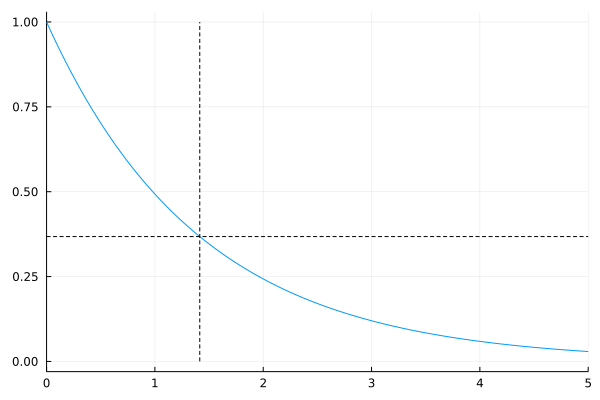

In [ ]:
plot(x, norm.(u), xlims = (0, 5), legend = :false)
plot!([sqrt(2), sqrt(2)], [0, 1], color = :black, style = :dash)
plot!([0, 5], [exp(-1), exp(-1)], color = :black, style = :dash)